# Smooth Sequential Waypoint Navigation Using Multi-Goal-Conditioned Policy Search, And Learned Termination Conditions

## 1. Introduction

### 1.1 Problem Statement
Our aim is to learn a policy that maps an arbitrary number of waypoints to smooth navigation behaviour between those waypoints. Whereas previous work [] has made use of path-planning policies to learn complex maneuvers, we believe that this is less beneficial than using waypoints for several key reasons:

1. Most mission-planning software still uses navigation between waypoints as the default paradigm. Motion planning is generally more costly, and limited to applications in which the full environment is known. Optimization is needed to conduct motion planning for *each* maneuver, which is inefficient, and biologically implausible.
2. In many cases, we may know the points we want to reach, but not necessarily the exact path. This type of reasoning is reminiscent of how humans often plan []. 
3. We can construct the task of waypoint navigation as a recycled skill that is repeatedly applied. This has potential benefits for learning, by recycling knowledge to learn a more complex task more quickly.

## 2. Background

### 2.1 Policy Search
We focus on the class of methods known as Monte Carlo policy gradients. We assume a Markov Decision Process, in which we denote a trajectory $\tau$ as an ordered set of events $\{s_{0}, a_{0}, r_{0}, s_{1}, ..., s_{T} \}$ for actions $a \in \mathcal{A}$, states $s \in \mathcal{S}$, and rewards $r \in \mathcal{R}$, where $t$ denotes an instantaneous point in time, and $T$ is the horizon. We assume a deterministic transition function given by the aircraft's flight dynamics.

Policy search algorithms learn a mapping $\pi_{\theta}:\mathcal{S} \rightarrow \mathcal{A}$, known as a policy, and adjust the policy's weights to maximize the expected return of a trajectory: 

\begin{equation}
\label{eqn:state_value_function}
    V^{\pi}(s_t) = \mathbb{E}_{\pi}\left[\sum_{t}^{T-1}\gamma^{t}r_{t}|s_{t}=s\right]
\end{equation}

\begin{equation}
\label{eqn:state_action_value}
    Q^{\pi}(s_t,a_t) = \mathbb{E}_{\pi}\left[\sum_{t}^{T-1}\gamma^{t}r_{t}|s_{t}=s, a_{t}=a\right]
\end{equation}

Where $V^{\pi}(s)$ and $Q^{\pi}(s,a)$ are the state and state-action value functions, respectively, that map $Q:\mathcal{S}\times\mathcal{A}\rightarrow\mathbb{R}$, and $V:\mathcal{S}\rightarrow\mathbb{R}$. $\gamma \in [0,1]$ is a discount factor that more heavily weights immediate rewards, and ensures convergence over an infinite horizon. The return is typically optimized using gradient ascent, in which the gradient is approximated using the score function estimator:

\begin{equation}
\label{eqn:policy_gradient}
    \nabla_{\theta}J(\theta) = \mathbb{E}_{\pi}\left[\sum_{t=0}^{T-1}\nabla_{\theta}\log{\pi_{\theta}(a_{t}|s_{t})}\Phi_{t}\right]
\end{equation}

Where $\pi_\theta(a|s)$ is a stochastic policy function parameterized by $\theta$, and $\Phi_t$ is an instantaneous measure of the agent's return. In practice, Monte Carlo trajectory roll-outs are conducted under the current policy, and an empirical estimate of $Q^{\pi}(s,a)$ (denoted $\hat{Q}^{\pi}(s,a)$) is calculated using Equation \ref{eqn:state_action_value}. Equation \ref{eqn:policy_gradient} is then used to calculate the gradient, where $\Phi_{t}$ is typically the empirical advantage estimate $\hat{A}^{\pi}(s,a)=\hat{Q}^{\pi}(s,a)-V_{\phi}^{\pi}(s)$. $V_{\phi}^{\pi}(s)$ is a parameterized function that estimates Equation \ref{eqn:state_value_function}, and is trained on the empirical returns from trajectory roll-outs.

Since Equation \ref{eqn:policy_gradient} is a high-variance estimator, modern policy gradient algorithms will often optimize the surrogate objective:

\begin{equation}
\label{eqn:modern_pg}
\begin{aligned}
    & \text{maximize:}
    & & \mathbb{E}_{s\sim\pi^{\prime}, a\sim\pi} \left[\sum_{t=0}^{T-1} \frac{\pi(a|s)}{\pi^{\prime}(a|s)} A^{\pi^{\prime}}(s_{t},a_{t})  \right] \\
    \\
    & \text{such that:} 
    & & DKL(\pi || \pi^{\prime}) \leq \delta
\end{aligned}
\end{equation}

Equation \ref{eqn:modern_pg} has the advantage of bounding the policy update to a trust region within which monotonic improvement can be guaranteed, thus improving learning stability. \ref{eqn:modern_pg} can be optimized using either constrained optimization, which results in Trust Region Policy Optimization (TRPO) or a first order approximation as is done in Proximal Policy Optimization (PPO).

In certain cases, it makes sense to split a single difficult task into multiple sub-tasks that are individually easier to learn, and then find some way of combining them together. This idea is the central focus of hierarchical reinforcement learning, typified by methods such as options, MAX-Q, parameterized skills, and feudal networks. Hierarchical RL modifies the standard RL formulation to include multiple sub-policies for individual skills, an initiation set $\mathcal{I}$ that determines when a policy can be activated, and a termination condition $\beta$ that dictates when a policy should cease running. Hierarchical RL can be combined with Universal Value Function Approximation (UVFA) to learn more general policies, typically using value function methods such as Q-learning, or online methods such as DDPG. We combine UVFAs with Monte Carlo policy gradients to learn more general policies, which we discuss in further detail in Section.

A closely related but distinct idea is that of auxiliary learning, in which an agent is trained to complete auxiliary tasks in addition to a given primary task.

### 2.2 Quadrotor Flight Dynamics
We briefly cover quadrotor flight dynamics here as it pertains to the learning problem.

Our aircraft is modeled in a NED axis system, and we use the full 6DOF nonlinear equations of motion:

\begin{equation}
    \begin{bmatrix}
		0 \\
		\mathbf{\dot{v}} \\
	\end{bmatrix} = 
	\begin{bmatrix}
		0 \\
		\mathbf{a}_{b}
	\end{bmatrix}
	+\mathbf{q}\otimes
	\begin{bmatrix}
		0 \\
		\mathbf{G}_{i}
	\end{bmatrix}\otimes
	\mathbf{q}^{-1}
	-\begin{bmatrix}
		0 \\
		\mathbf{\omega} \times \mathbf{v}
	\end{bmatrix}
\end{equation}

\begin{equation}
	\mathbf{\dot{\omega}} = \mathbf{J}^{-1}(\mathbf{M}_{b}-\mathbf{\omega}\times \mathbf{J}\mathbf{\omega})
\end{equation}

\begin{equation}	
	\begin{bmatrix}
		0 \\
		\mathbf{\dot{x}}
	\end{bmatrix} = \mathbf{q}^{-1} \otimes 
	\begin{bmatrix}
		0 \\
		\mathbf{v}
	\end{bmatrix} \otimes
	\mathbf{q}
\end{equation}

\begin{equation}
    \mathbf{\dot{q}} = -\frac{1}{2}
    \begin{bmatrix}
		0 \\\omega 
	\end{bmatrix}\otimes\mathbf{q}
\end{equation}

We model the motor thrust and torque as being $\propto \Omega^2$, with motor lag characterized by a linear first-order ODE:

\begin{equation}
\dot{\Omega} = -k_{\Omega}(\Omega-\Omega_{C})
\end{equation}

We include a simple aerodynamic force and moment model:

\begin{equation}
F_A = -k_F ||{\mathbf{v}}|| \mathbf{v}
\end{equation}

\begin{equation}
Q_A = -k_Q \mathbf{\omega}
\end{equation}

Our model is implemented in C++, with code generated using MATLAB Simulink. We wrote Python wrappers for the code so that we could interface it with standard Python ML libraries such as PyTorch, and test our own agents on standard benchmarks. We did this as we found that existing packages such as AirSim and Gazebo were unsuited to training agents at speeds faster than real-time, and that their decentralized nature made controlling action-selection frequency difficult (and largely dependent on hardware). Furthermore, previous works such as [] have demonstrated the efficacy of using simple models to train aircraft-ready policies. All environments used in our experiments can be accessed online at https://github.com/seanny1986/gym-aero/. We provide an OpenGL-based visualization module along with the basic simulator.

Actions in quadrotors are additive, meaning that -- for example -- if we want to travel in a diagonal direction, we can add actions for going forwards and going sideways in order to do so. This is a common strategy in designing quadrotor controllers -- we can nest them and additively compose actions using controllers designed for different roles (e.g. combining a hover controller with a tracking controller). Furthermore, quadrotors do not need to face "fowards" into the direction of flight, and can translate in any direction without having to yaw into the direction of travel. Nevertheless, this is a constraint we would like to impose, as it reflects the way in which human pilots fly. This breaks many of the symmetries inherent in quadrotor flight, but provides us with a more interesting learning problem.


## 3. Methodology
We pose this problem as a skill learning task, in which the same skill is repeatedly applied. This is in contrast to other hierarchical methods such as options, in which a fixed number of policies are provided at the start of training, and a set of abstracted "skills" is learned. Looking at Fig. X, we want to fly some arbitrary trajectory between a set of waypoints, in which the shortest path from A to B is simply a straight line, but the optimal path through the points involves modifying the straight line path in some small way.

In principle, if we know how to get from points A to B, then we should also be able to get from B to C, so long as the underlying dynamics of the problem are preserved. To make use of this insight, we propose a sliding-window type approach, in which our agent moves to a given waypoint, and we then update the origin of the agent's coordinate frame to the new position. In this way, the agent is effectively solving the same problem repeatedly. This representation is in stark contrast to standard feature representations on learning tasks, which often involve normalizing inputs in some way.

The advantages of this representation are numerous:

1. We don't need to keep track of statistics, because by definition, we can always choose a point within some local horizon, and reset the agent's position to be the origin. Blowup due to the observation space is effectively impossible, since all inputs are bounded.
2. 

The downsides of this representation are that it induces a discrete shift in the agent's observation space, which has a number of consequences. Though we will show these explicitly further on, we will describe them here a:

1. "Creeping", in which the agent creeps up to a goal, but never quite triggers it.
2. "Jumping", in which the agent "jumps" from goal to goal in a sharp manner, and doesn't exhibit the smooth flight that we desire.

Furthermore, our new state representation requires careful sequencing of the shift in order to ensure that our agent is able to learn.

We hypothesise that these problems are caused by the discrete shift in the agent's origin, and propose two fixes:

1. A soft boundary that has a probability to trigger based on distance from the goal; and,
2. Treating this as an auxiliary learning task, and adding a termination policy that learns when a given goal has been reached such that the agent should move to the next one. This is an auxiliary learning task because the agent must balance trying to maximize the return from the trajectory, and the reward for switching to the next goal when close to the current one.

Knowing when a goal has been reached is an important component of human intelligence, and is thus of interest here.

## 4. Implementations
In the following block of code, we implement our termination policy by inheriting from our own TRPO-PEB class, and including some additional methods.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.distributions import Categorical
from math import exp

from algs.ind import trpo_peb
import config as cfg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Sequential(
                                self.fc1,
                                nn.Tanh(),
                                self.fc2,
                                nn.Tanh(),
                                nn.Linear(hidden_dim, output_dim)
                                )
        
        self.logvar = nn.Sequential(
                                self.fc1,
                                nn.Tanh(),
                                self.fc2,
                                nn.Tanh(),
                                nn.Linear(hidden_dim, output_dim)
                                )
        
        #self.mu.weight.data.mul_(0.1)
        #self.mu.bias.data.mul_(0.)

    def forward(self, x):
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

class Terminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Terminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, 1)
        self.score = nn.Linear(hidden_dim, output_dim)
        self.value = nn.Linear(hidden_dim, 1)
    
    def step(self, x, hidden=None):
        hx, cx = self.lstm(x.unsqueeze(1), hidden)
        score = F.softmax(self.score(hx.squeeze(1)), dim=-1)
        value = self.value(hx.squeeze(1))
        return score, value, cx

    def forward(self, x, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(x)
        scores = torch.zeros(steps, 1, 1)
        values = torch.zeros(steps, 1, 1)
        for i in range(steps):
            if force or i == 0:
                input = x[i]
            score, value, hidden = self.step(input, hidden)
            scores[i] = score
            values[i] = value
        return scores, values, hidden
    
class Agent(trpo_peb.TRPO):
    def __init__(self, pi, beta, critic, terminator, params):
        super(Agent, self).__init__(pi, beta, critic, params)
        self.terminator = terminator.to(self.device)
        self.gamma = params["gamma"]
        self.tau = params["tau"]
        self.max_kl = params["max_kl"]
        self.damping = params["damping"]
    
    def terminate(self, x, hidden=None):
        score, value, hidden = self.terminator.step(x.view(1,-1), hidden)
        dist = Categorical(score)
        term = dist.sample()
        logprob = dist.log_prob(term)
        return term, value, hidden, logprob
    
    def update(self, crit_opt, term_opt, trajectory):
        rewards = torch.stack(trajectory["rewards"])
        masks = torch.stack(trajectory["masks"])
        states = torch.stack(trajectory["states"])
        next_states = torch.stack(trajectory["next_states"])
        term_log_probs = torch.stack(trajectory["term_log_probs"])
        term_rews = torch.stack(trajectory["term_rew"])
        term_vals = torch.stack(trajectory["term_val"]).squeeze(1)
        term_hiddens = trajectory["hiddens"]
        hxs = torch.stack([x[0] for x in term_hiddens])
        cxs = torch.stack([x[1] for x in term_hiddens])
        
        term_returns = torch.Tensor(rewards.size(0),1).to(device)
        term_deltas = torch.Tensor(rewards.size(0),1).to(device)
        term_advantages = torch.Tensor(rewards.size(0),1).to(device)
        
        term_prev_return = 0
        term_prev_value = 0
        term_prev_advantage = 0
        for i in reversed(range(rewards.size(0))):
            if masks[i] == 0:
                _, term_next_val, _, _ = self.terminate(next_states[i].unsqueeze(0), (hxs[i], cxs[i]))
                term_prev_return = term_next_val.item()
                term_prev_value = term_next_val.item()
            
            term_returns[i] = rewards[i]+term_rews[i]+self.gamma*term_prev_return*masks[i]
            term_deltas[i] = rewards[i]+term_rews[i]+self.gamma*term_prev_value*masks[i]-term_vals.data[i]
            term_advantages[i] = term_deltas[i]+self.gamma*self.tau*term_prev_advantage*masks[i]
            
            term_prev_return = term_returns[i, 0]
            term_prev_value = term_vals.data[i, 0]
            term_prev_advantage = term_advantages[i, 0]
            
        term_returns = (term_returns-term_returns.mean())/(term_returns.std()+1e-10)
        term_advantages = (term_advantages-term_advantages.mean())/(term_advantages.std()+1e-10)
        
        # update terminator
        term_opt.zero_grad()
        term_crit_loss = F.smooth_l1_loss(term_vals, term_returns)
        term_pol_loss = -term_log_probs*term_advantages 
        term_loss = term_pol_loss+term_crit_loss
        term_loss = term_loss.mean()
        term_loss.backward()
        term_opt.step()
        
        # call the base update function
        super(Agent, self).update(crit_opt, trajectory)

/home/seanny/anaconda2/envs/python3.5/lib/python3.5/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Next, we will inherit from the basic hierarchical task to include our termination policy step. For simplicity, we will make all of the changes we need in the step function, and return the termination policy reward in the info dictionary:

In [2]:
import gym
import gym_aero
import gym_aero.envs.trajectory_env as trajectory_env

class TrajectoryEnvTerm(trajectory_env.TrajectoryEnv):
    def __init__(self):
        super(TrajectoryEnvTerm, self).__init__()

    def term_reward(self, state):
        xyz, _, _, _, _ = state
        u = sum([(x-g)**2 for x, g in zip(xyz, self.goal_xyz)])**0.5
        v = sum([(x-g)**2 for x, g in zip(xyz, self.goal_xyz_next)])**0.5
        return -15*u**2-0*u*v

    def step(self, action, term):
        # translate action output of controller to simulation rpm
        commanded_rpm = self.translate_action(action)

        # step simulation forward
        xyz, zeta, uvw, pqr = super(trajectory_env.TrajectoryEnv, self).step(commanded_rpm)
        
        # calculate state representation values
        sin_zeta = [sin(z) for z in zeta]
        cos_zeta = [cos(z) for z in zeta]
        current_rpm = self.get_rpm()
        normalized_rpm = [rpm/self.max_rpm for rpm in current_rpm]

        # calculate current distances from goals
        self.set_current_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)

        # calculate reward based on distances
        reward, info = self.reward((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        term_rew = self.term_reward((xyz, sin_zeta, cos_zeta, uvw, pqr)) if term == 1 else 0.
                    
        # if agent is within goal threshold, switch to next goal
        if term == 1: self.next_goal()

        # check if terminal
        done = self.terminal()

        # get state observation
        obs = self.get_state_obs((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        
        # set previous distances
        self.set_prev_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        
        info.update({"term_rew" : term_rew})
        
        # increment time
        self.t += 1
        return obs, reward, done, info

Finally, we will write two basic training loops below. The first is for the standard agent, and the second is for the agent that has been modified with the termination policy. Aside from querying the termination policy and passing the termination reward to the update function, both algorithms are exactly the same. Similarly, we measure them using the same reward function.

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(episodes, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (episodes[-1], rewards[-1]))
    plt.plot(episodes, rewards)
    plt.show()
    
def test_agent(env, agent):
    state = torch.Tensor(env.reset()).to(device)
    reward_sum = 0.
    done = False
    while not done:
        action, value, log_prob = agent.select_action(state)
        next_state, reward, done, info = env.step(action.cpu().data.numpy())
        reward_sum += reward
        next_state = torch.Tensor(next_state).to(device)
        state = next_state
    return reward_sum

def test_term(env, agent):
    state = torch.Tensor(env.reset()).to(device)
    reward_sum = 0
    hidden = None
    done = False
    while not done:
        action, value, log_prob = agent.select_action(state)
        term, term_val, hidden, term_log_prob = agent.terminate(state, hidden)
        next_state, reward, done, info = env.step(action.cpu().data.numpy(), term.cpu().item())
        term_rew = info["term_rew"]
        reward_sum += reward
        next_state = torch.Tensor(next_state).to(device)
        state = next_state    
    return reward_sum
    
def rollout(env, agent, batch_size=2048, render=False):
    s_, a_, ns_, r_, lp_, t_lp_, masks, g_ = [], [], [], [], [], [], [], []
    num_steps = 0
    while num_steps < batch_size:
        state = torch.Tensor(env.reset()).to(device)
        t = 0
        done = False
        while not done:
            if render: env.render()
            action, value, log_prob = agent.select_action(state)
            next_state, reward, done, info = env.step(action.cpu().data.numpy())
            
            next_state = torch.Tensor(next_state).to(device) 
            reward = torch.Tensor([reward]).to(device)
            
            s_.append(state)
            ns_.append(next_state)
            a_.append(action)
            r_.append(reward)
            lp_.append(log_prob)
            masks.append(torch.Tensor([not done]).to(device))
            
            g_.append(env.goal_xyz)    
            state = next_state
            t += 1
        num_steps += t
    if render: env.render(close=True)
    trajectory = {
                "states": s_,
                "actions": a_,
                "rewards": r_,
                "next_states": ns_,
                "masks": masks,
                "log_probs": lp_,
                "goals":g_
                }
    return trajectory

def term_rollout(env, agent, batch_size=2048, render=False):
    s_, a_, ns_, r_, lp_, t_lp_, masks, g_ = [], [], [], [], [], [], [], []
    t_r_, t_v_, t_h_, t_a_ = [], [], [], []
    num_steps = 0
    while num_steps < batch_size:
        state = torch.Tensor(env.reset()).to(device)
        t = 0
        hidden = None
        done = False
        while not done:
            if render: env.render()
            action, value, log_prob = agent.select_action(state)
            term, term_val, hidden, term_log_prob = agent.terminate(state, hidden)
            next_state, reward, done, info = env.step(action.cpu().data.numpy(), term.cpu().item())
            term_rew = info["term_rew"]
            
            next_state = torch.Tensor(next_state).to(device)    
            reward = torch.Tensor([reward]).to(device)
            term_rew = torch.Tensor([term_rew]).to(device)
                
            s_.append(state)
            ns_.append(next_state)
            a_.append(action)
            r_.append(reward)
            lp_.append(log_prob)
            masks.append(torch.Tensor([not done]).to(device))
                
            t_lp_.append(term_log_prob)
            t_r_.append(term_rew)
            t_v_.append(term_val)
            t_h_.append(hidden)
            t_a_.append(term)
            
            g_.append(env.goal_xyz)
            state = next_state
            t += 1
        num_steps += t
    if render: env.render(close=True)
    trajectory = {
                "states": s_,
                "actions": a_,
                "rewards": r_,
                "next_states": ns_,
                "masks": masks,
                "log_probs": lp_,
                "term_log_probs": t_lp_,
                "term_rew": t_r_,
                "term_val": t_v_,
                "hiddens": t_h_,
                "terminations": t_a_,
                "goals": g_
                }
    return trajectory
    
def train_standard(env, agent, crit_opt, iterations=1000, batch_size=2048, log_interval=10, render=False, fname=None):
    rews = []
    eps = []
    for ep in range(1, iterations+1):
        trajectory = rollout(env, agent, batch_size, render=render)
        agent.update(crit_opt, trajectory)
        if ep % log_interval == 0:
            eps.append(ep)
            test_rew = np.mean([test_agent(env, agent) for _ in range(10)])
            rews.append(test_rew) 
            plot(eps, rews)
    if fname is not None: torch.save(agent.state_dict(), fname+"_standard.pth.tar")
    env.render(close=True)
    return eps, rews, agent

def train_term(env, agent, crit_opt, term_opt, iterations=1000, batch_size=2048, log_interval=10, render=False, fname=None):
    rews = []
    eps = []
    for ep in range(1, iterations+1):
        trajectory = term_rollout(env, agent, batch_size, render=render)
        agent.update(crit_opt, term_opt, trajectory)
        if ep % log_interval == 0:
            eps.append(ep)
            test_rew = np.mean([test_term(env, agent) for _ in range(10)])
            rews.append(test_rew) 
            plot(eps, rews)
    if fname is not None: torch.save(agent.state_dict(), fname+"_term.pth.tar")
    env.render(close=True)
    return eps, rews, agent

## 5. Experiments
We conduct the following experiments:

1. We test a standard agent on the task of flying between sequential waypoints. We vary the goal threshold to show that the performance of the agent is highly dependent on this single parameter, and that we can essentially "hack" the performance of the agent;
2. We test our own architecture using learned termination conditions and show that it doesn't suffer from this problem;
3. We compare the agents on the basis of acceleration to show that ours exhibits smoother flight;
4. We test an option-critic agent, and show that it performs no better than the standard agent;
5. We show that our method does not make effective use of future waypoints, but that -- given the right reward function -- the standard agent *can*.
6. We show that using a projected gradient, we can produce a general flight policy that maps waypoints to smooth navigation. 
7. We compare our waypoint-based agents with an agent that is trained to follow a path along a spline, and show that our method is more general by altering the trajectory length; and,

All agents are trained using the *exact same* reward function and weightings. To make this explicit, we include the reward function below, and pass it to the environment for training. We will repeat this step for all test environments:


In [5]:
from math import sin, cos

def reward_func(self, state, action, normalized_rpm):
        xyz, sin_zeta, cos_zeta, uvw, pqr = state

        # agent gets a negative reward based on how far away it is from the desired goal state
        guide_rew = 1/self.curr_dist if self.curr_dist > self.goal_thresh else 1/self.goal_thresh
        dist_rew = 100*(self.prev_dist-self.curr_dist+guide_rew)
        att_rew = 100*(self.prev_att_sin+self.prev_att_cos-self.curr_att_sin-self.curr_att_cos)
        vel_rew = 50*(self.prev_vel-self.curr_vel)
        ang_rew = 50*(self.prev_ang-self.curr_ang)

        # agent gets a negative reward for excessive action inputs
        ctrl_rew = -sum([((a-self.hov_rpm)/self.max_rpm)**2 for a in action])
        ctrl_rew -= sum([((a-pa)/self.max_rpm)**2 for a, pa in zip(action, self.prev_action)])
        ctrl_rew -= 0*sum([(x-y)**2 for x, y in zip(xyz, self.prev_xyz)])
        ctrl_rew -= 0*sum([(z-sin(k))**2 for z, k in zip(sin_zeta, self.prev_zeta)])
        ctrl_rew -= 0*sum([(z-cos(k))**2 for z, k in zip(cos_zeta, self.prev_zeta)])
        ctrl_rew -= 10*sum([(u-v)**2 for u, v in zip(uvw, self.prev_uvw)])
        ctrl_rew -= 10*sum([(p-q)**2 for p, q in zip(pqr, self.prev_pqr)])

        # time reward for staying in the air
        time_rew = 0.

        # calculate total reward
        total_reward = dist_rew+att_rew+vel_rew+ang_rew+ctrl_rew+time_rew
        return total_reward, {"dist_rew": dist_rew, 
                                "att_rew": att_rew, 
                                "vel_rew": vel_rew,
                                "ang_rew": ang_rew,
                                "ctrl_rew": ctrl_rew,
                                "time_rew": time_rew}

All of our agents use the same observation space:

\begin{equation}
\mathbf{O} = \left[\mathbf{X_i-X_{i_{g}}^{(n)}},\, \mathbf{Z-Z_{g}^{(n)}},\, \mathbf{V-V_{g}^{(n)}},\, \mathbf{X_{i}-X_{i_{g}}^{(n+1)}},\, \mathbf{Z-Z_{g}^{(n+1)}},\, \mathbf{V-V_{g}^{(n+1)}},\, \mathbf{\Omega},\, T_{max}-t\right]
\end{equation}

Where $\mathbf{X}_{i}$ is the position of the aircraft relative to its current datum in the inertial frame, $\mathbf{Z} = \left[\sin(\mathbf{\zeta}),\, \cos(\mathbf{\zeta})\right]$, where $\zeta$ corresponds to the roll pitch and yaw of the aircraft ($\zeta = [\phi,\, \theta,\, \psi]$), $\mathbf{V}=[\mathbf{U}_{b},\, \omega]$ -- the linear velocity in the body frame, and the angular velocity. $T_{max}-t$ is the remaining time for the aircraft to complete the task of moving to the next goal, with $T_{max}$ being the maximum alloted time, and $t$ being the current time elapsed. When $t=T_{max}$, the episode is terminated. If the aircraft reaches the current waypoint, $t$ is reset to zero. $\Omega$ is the current RPM of the vehicle's rotors.

We set the goal velocities to be zero as a proxy for finding the minimum-energy configuration for reaching the next waypoint. This has the added benefit of training the policy to fly as slowly as possible, meaning it uses the full allocated time for reaching the next goal.

We use the following settings for the aircraft simulation:

|Parameter Name                   |Parameter Value|Unit      |
|---------------------------------|:-------------:|----------|
|Mass                             |0.65           |kg        |
|Propeller Radius                 |0.06           |m         |
|Number of motors                 |4              |N/A       |
|Hover thrust %                   |50             |%         |
|Momemt arm length                |0.23           |m         |
|Thrust coefficient               |3e-5           |N/A       |
|Torque coefficient               |3e-7           |N/A       |
|Drag coefficient                 |9e-3           |N/A       |
|Aerodynamic moment coefficient   |9e-4           |N/A       |
|Motor decay coefficient          |5.56           |N/A       |
|Gravity                          |9.81           |$m/s^{2}$|
|Maximum RPM                      |3600           |rpm       |
|Hover RPM                        |2800           |rpm       |
|Maximum Thrust                   |3.18825        |N/motor   |
|Hover Thrust                     |1.59413        |N/motor   |

## 6. Results

Below, we implement and run code for the above experiments. In addition, we perform some basic analysis to determine the strengths and weaknesses of our proposal.

### 6.1 Experiment 1 -- Validating the Standard Agent
Our first objective is to test the standard agent, and to determine whether or not it can learn effectively through a discontinuous shift in the observation space. For this task we use TRPO; we modify the training algorithm slightly to take tail costs into account, since this a continuing task. Our training parameters are:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|KL-Divergence         |1e-2           |N/A |
|Tau                   |1e-2           |N/A |
|Critic stepsize       |1e-4           |N/A |
|Goal threshold radius |0.1            |m   |
|Batch-size            |2048           |N/A |
|Iterations            |1000           |N/A |
|Network hidden layers |2              |N/A |
|Network hidden neurons|256            |N/A |


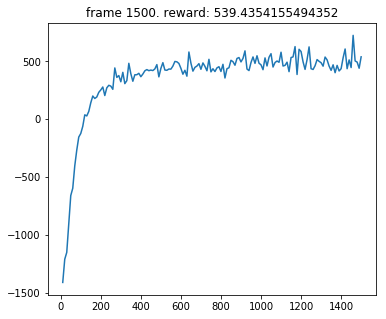

In [11]:
from types import MethodType

env_one = gym.make("Trajectory-v0")
env_one.goal_thresh = 0.1
env_one.reward = MethodType(reward_func, env_one)

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1))
agent = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
ep, rew, agent = train_standard(env_one, agent, crit_opt, batch_size=2048, iterations=1500, log_interval=10, render=False, fname="main_0.1_rad")
agents, episodes, rewards = [], [], []
agents.append(agent)
episodes.append(ep)
rewards.append(rew)

#### 6.1.1 Visualization

In [6]:
env_one = gym.make("Trajectory-v0")

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

fname = "main_0.1_rad_standard.pth.tar"
pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
        torch.nn.Linear(state_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, 1))
agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
agent_check.load_state_dict(torch.load("./"+fname))
_ = rollout(env_one, agent_check, batch_size=2048, render=True)

[2019-07-15 13:29:45,925] Making new env: Trajectory-v0


Simulation parameters:
Aircraft mass:  0.6499999761581421
Gravity:  9.8100004196167
Torque coefficient:  7.500000265281415e-07
Thrust coefficient:  3.1299998227041215e-05
Maximum RPM:  3047.722428374999
Hover RPM:  2155.0651962782936
Hover Omega:  225.6778996211644
Action bandwidth:  334.22538049298026


### 6.2 Experiment 2 -- Varying Goal Threshold Radius
One issue with goal-based policies is the problem of knowing when a goal has been reached. In works such as [], it's common to use a discrete threshold, but in our case this can cause problems. Since we chain waypoints together, discrete boundaries can result in undesirable behaviors, and -- even worse -- have a direct impact on the reward that the agent is able to achieve. Below, we show that we can essentially "hack" the return of the policy through careful selection of a discrete goal threshold radius. This diminishes the usefulness of the reward as a measure of the agent's effectiveness. For this reason, we opt to use a measure of smoothness of the flight trajectory instead, when validating our agents.

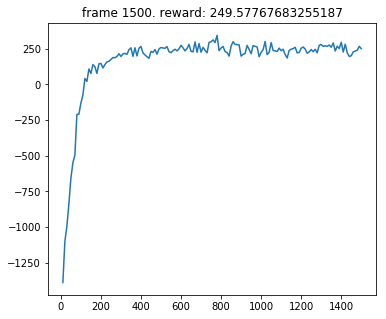

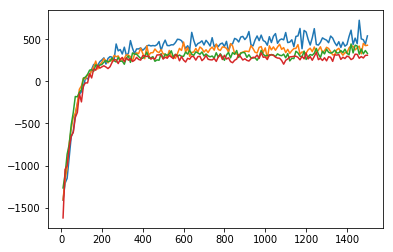

In [12]:
import matplotlib.pyplot as plt
from types import MethodType

env_one = gym.make("Trajectory-v0")
env_one.reward = MethodType(reward_func, env_one)

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]
radii = [0.15, 0.2, 0.25, 0.3]
rad = []
agents = []
for r in radii:
    env_one.goal_thresh = r
    pi = Actor(state_dim, hidden_dim, action_dim)
    beta = Actor(state_dim, hidden_dim, action_dim)
    critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1))
    temp_agent = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
    crit_opt = torch.optim.Adam(critic.parameters())
    ep, rew, temp_agent = train_standard(env_one, temp_agent, crit_opt, batch_size=2048, iterations=1500, log_interval=10, fname=str(r)+"_rad")    
    episodes.append(ep)
    rewards.append(rew)
    rad.append(r)
    agents.append(temp_agent)

labels = ["radius 0.10",
          "radius 0.15",111
          "radius 0.20",
          "radius 0.25",
          "radius 0.30",
          "learned term"]
ax = plt.axes()
for e, r, ra in zip(episodes, rewards, rad):
    ax.plot(e, r)
ax.legend(labels)
plt.show()

As we can see, a larger threshold around the waypoint makes it easier to reach, which translates to much better returns. The effectiveness decreases as the goal threshold increases, because once an agent is able to reliably complete the task, increasing the goal threshold starts to slightly decrease the maximum reward that can be achieved.

If this is the case, then why not just set the goal threshold at whatever is the optimum value? I.e. why not pick the threshold with the best average return? The answer is because:

1. The best performing goal thresholds in this case make the task substantially easier. For example, when the goal is 1m away, and the aircraft has a rough radius of 0.2m, the larger goal thresholds are roughly as large -- or larger -- than the aircraft itself.
2. The discrete goal boundary still results in the aforementioned problematic behaviours. We can show this by plotting the acceleration in the inertial x, y and z axes below:

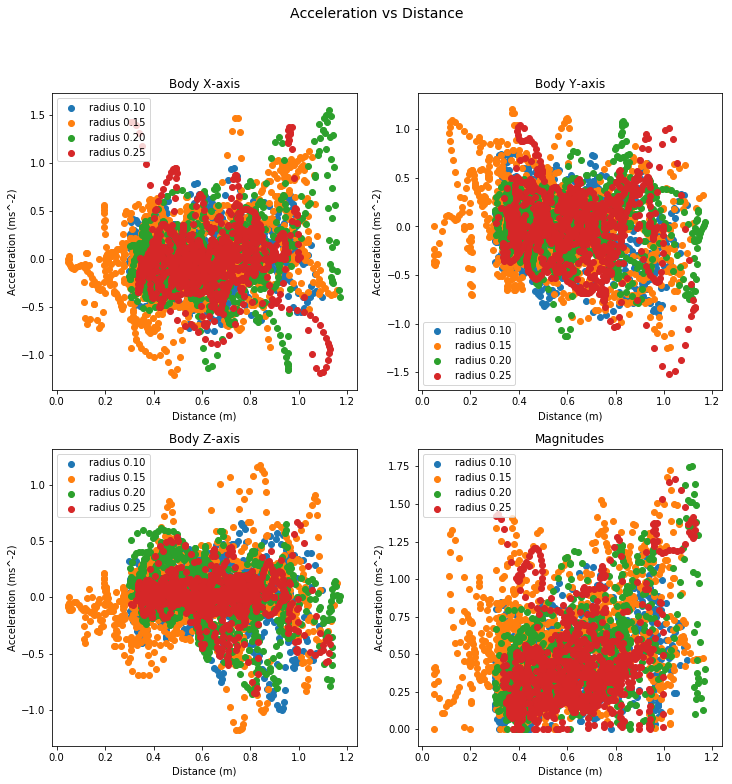

In [13]:
labels = ["radius 0.10",
          "radius 0.15",
          "radius 0.20",
          "radius 0.25",
          "radius 0.30",
          "learned term"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle("Acceleration vs Distance", fontsize=14)

ax1.set_title("Body X-axis")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Acceleration (ms^-2)")

ax2.set_title("Body Y-axis")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Acceleration (ms^-2)")

ax3.set_title("Body Z-axis")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Acceleration (ms^-2)")

ax4.set_title("Magnitudes")
ax4.set_xlabel("Distance (m)")
ax4.set_ylabel("Acceleration (ms^-2)")

for agent in agents:
    trajectory = rollout(env_one, agent, batch_size=1024)
    states = torch.stack(trajectory["states"])
    masks = torch.stack(trajectory["masks"])
    derivatives = torch.stack([(states[i]-states[i-1])*(masks[i-1,0]/0.05) for i in range(1, states.size(0))])
    goal_dist = torch.sqrt(torch.sum(states[0:-1, 0:3]**2, dim=1)).unsqueeze(dim=1)
    ax1.scatter(goal_dist.cpu().numpy(), derivatives[:,9+0].cpu().numpy())
    ax2.scatter(goal_dist.cpu().numpy(), derivatives[:,9+1].cpu().numpy())
    ax3.scatter(goal_dist.cpu().numpy(), derivatives[:,9+2].cpu().numpy())
    normed = (derivatives[:,9+0].cpu().numpy()**2+derivatives[:,9+1].cpu().numpy()**2+derivatives[:,9+2].cpu().numpy()**2)**0.5
    ax4.scatter(goal_dist, normed)

ax1.legend(labels)
ax2.legend(labels)
ax3.legend(labels)
ax4.legend(labels)
plt.show()

#### 6.2.1 Visualization

In [ ]:
env_one = gym.make("Trajectory-v0")

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

fname = "main_0.1_rad_standard.pth.tar"
pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
        torch.nn.Linear(state_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, 1))
agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
agent_check.load_state_dict(torch.load("./"+fname))
_ = rollout(env_one, agent_check, batch_size=2048, render=True)

### 6.2 Experiment 3 -- Learning Termination Conditions Directly

Having shown that we can indeed train an agent through a shift in the observation space, and having identified some of the problems inherent in goal-based policies, we will now add the additional component of learned termination conditions. That is, the agent should learn *when* it has sufficiently reached the next goal, such that it should move to the next one. Our policy parameters are the same as for the previous experiment, and we use the exact same reward function. This time, we include a termination policy with the following parameters:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|Network type          |LSTM           |N/A |
|Network fully-connected layers |1              |N/A |
|Network hidden neurons|256            |N/A |
|Learning rate         |1e-4           |N/A |

As covered in Section 3, the update rule for the termination policy is:

\begin{equation}
STUFF
\end{equation}

In this case, we don't need to set the goal threshold -- we will just set the reward function to the standard one we used earlier.

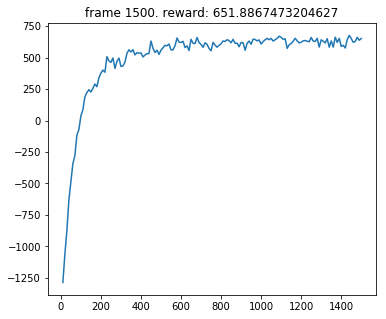

In [14]:
from types import MethodType

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )
terminator = Terminator(state_dim, hidden_dim, 2)
term_agent = Agent(pi, beta, critic, terminator, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
term_opt = torch.optim.Adam(terminator.parameters())
term_ep, term_rew, term_agent = train_term(env_two, term_agent, crit_opt, term_opt, batch_size=2048, iterations=1500, log_interval=10, fname="log_gaussian")

As we can see, the agent that selects its own waypoints fares substantially better than the standard agents with a small discrete goal threshold, and does about as well as the agent with a 0.15m threshold radius.

#### 6.3.1 Visualization

In [ ]:
env_one = gym.make("Trajectory-v0")

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

fname = "log_gaussian_term.pth.tar"
pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
        torch.nn.Linear(state_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, 1))
agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
agent_check.load_state_dict(torch.load("./"+fname))
_ = rollout(env_one, agent_check, batch_size=2048, render=True)

### 6.4 Analysis -- Comparison of Termination Policy Value Functions

#### 6.4.1 Goal Distance Only
One of the assertions made in Section 3 was that the termination policy needed to be trained on the return of control policy as well as the reward component for switching close to the waypoint. To test this, we train a termination policy by only giving it a negative penalty based on distance from the goal. Trivially, the agent learns to never switch to the next waypoint:

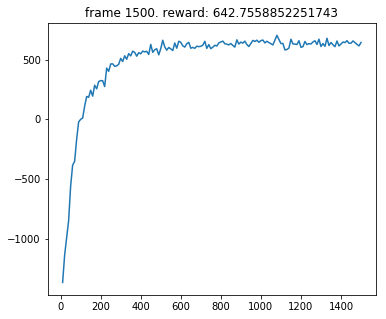

In [15]:
from types import MethodType

class AgentII(Agent):
    def __init__(self, pi, beta, critic, terminator, params):
        super(AgentII, self).__init__(pi, beta, critic, terminator, params)
        
    def update(self, crit_opt, term_opt, trajectory):
        rewards = torch.stack(trajectory["rewards"])
        masks = torch.stack(trajectory["masks"])
        states = torch.stack(trajectory["states"])
        next_states = torch.stack(trajectory["next_states"])
        term_log_probs = torch.stack(trajectory["term_log_probs"])
        term_rews = torch.stack(trajectory["term_rew"])
        term_vals = torch.stack(trajectory["term_val"]).squeeze(1)
        term_hiddens = trajectory["hiddens"]
        hxs = torch.stack([x[0] for x in term_hiddens])
        cxs = torch.stack([x[1] for x in term_hiddens])
        
        term_returns = torch.Tensor(rewards.size(0),1).to(self.device)
        term_deltas = torch.Tensor(rewards.size(0),1).to(self.device)
        term_advantages = torch.Tensor(rewards.size(0),1).to(self.device)
        
        term_prev_return = 0
        term_prev_value = 0
        term_prev_advantage = 0
        
        for i in reversed(range(rewards.size(0))):
            if masks[i] == 0:
                _, term_next_val, _, _ = self.terminate(next_states[i].unsqueeze(0), (hxs[i], cxs[i]))
                term_prev_return = term_next_val.item()
                term_prev_value = term_next_val.item()
            
            term_returns[i] = term_rews[i]+self.gamma*term_prev_return*masks[i]
            term_deltas[i] = term_rews[i]+self.gamma*term_prev_value*masks[i]-term_vals.data[i]
            term_advantages[i] = term_deltas[i]+self.gamma*self.tau*term_prev_advantage*masks[i]
            
            term_prev_return = term_returns[i, 0]
            term_prev_value = term_vals.data[i, 0]
            term_prev_advantage = term_advantages[i, 0]
            
        term_returns = (term_returns-term_returns.mean())/(term_returns.std()+1e-10)
        term_advantages = (term_advantages-term_advantages.mean())/(term_advantages.std()+1e-10)
        
        # update terminator
        term_opt.zero_grad()
        term_crit_loss = F.smooth_l1_loss(term_vals, term_returns)
        term_pol_loss = -term_log_probs*term_advantages 
        term_loss = term_pol_loss+term_crit_loss
        term_loss = term_loss.mean()
        term_loss.backward()
        term_opt.step()
        
        # call the base update function
        super(Agent, self).update(crit_opt, trajectory)

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )
terminator = Terminator(state_dim, hidden_dim, 2)
term_agent = AgentII(pi, beta, critic, terminator, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
term_opt = torch.optim.Adam(terminator.parameters())
term_ep, term_rew, term_agent = train_term(env_two, term_agent, crit_opt, term_opt, batch_size=2048, iterations=1500, log_interval=10, fname="mu_val")

##### 6.4.1.1 Visualization

In [ ]:
env_one = gym.make("Trajectory-v0")

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

fname = "mu_val_term.pth.tar"
pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
        torch.nn.Linear(state_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, 1))
agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
agent_check.load_state_dict(torch.load("./"+fname))
_ = rollout(env_one, agent_check, batch_size=2048, render=True)

#### 6.4.2 Control Policy Value Only

Next, we'll try training the agent on only the return of the flight control policy:

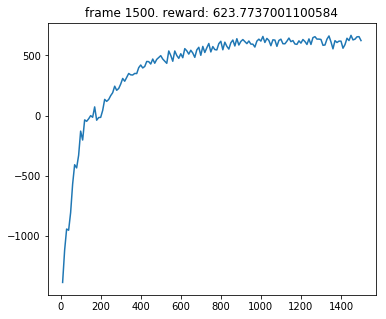

In [16]:
from types import MethodType

class AgentIII(Agent):
    def __init__(self, pi, beta, critic, terminator, params):
        super(AgentIII, self).__init__(pi, beta, critic, terminator, params)
        
    def update(self, crit_opt, term_opt, trajectory):
        rewards = torch.stack(trajectory["rewards"])
        masks = torch.stack(trajectory["masks"])
        states = torch.stack(trajectory["states"])
        next_states = torch.stack(trajectory["next_states"])
        term_log_probs = torch.stack(trajectory["term_log_probs"])
        term_rews = torch.stack(trajectory["term_rew"])
        term_vals = torch.stack(trajectory["term_val"]).squeeze(1)
        term_hiddens = trajectory["hiddens"]
        hxs = torch.stack([x[0] for x in term_hiddens])
        cxs = torch.stack([x[1] for x in term_hiddens])
        
        term_returns = torch.Tensor(rewards.size(0),1).to(self.device)
        term_deltas = torch.Tensor(rewards.size(0),1).to(self.device)
        term_advantages = torch.Tensor(rewards.size(0),1).to(self.device)
        
        term_prev_return = 0
        term_prev_value = 0
        term_prev_advantage = 0
        
        for i in reversed(range(rewards.size(0))):
            if masks[i] == 0:
                _, term_next_val, _, _ = self.terminate(next_states[i].unsqueeze(0), (hxs[i], cxs[i]))
                term_prev_return = term_next_val.item()
                term_prev_value = term_next_val.item()
            
            term_returns[i] = rewards[i]+self.gamma*term_prev_return*masks[i]
            term_deltas[i] = rewards[i]+self.gamma*term_prev_value*masks[i]-term_vals.data[i]
            term_advantages[i] = term_deltas[i]+self.gamma*self.tau*term_prev_advantage*masks[i]
            
            term_prev_return = term_returns[i, 0]
            term_prev_value = term_vals.data[i, 0]
            term_prev_advantage = term_advantages[i, 0]
            
        term_returns = (term_returns-term_returns.mean())/(term_returns.std()+1e-10)
        term_advantages = (term_advantages-term_advantages.mean())/(term_advantages.std()+1e-10)
        
        # update terminator
        term_opt.zero_grad()
        term_crit_loss = F.smooth_l1_loss(term_vals, term_returns)
        term_pol_loss = -term_log_probs*term_advantages 
        term_loss = term_pol_loss+term_crit_loss
        term_loss = term_loss.mean()
        term_loss.backward()
        term_opt.step()
        
        # call the base update function
        super(Agent, self).update(crit_opt, trajectory)

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )
terminator = Terminator(state_dim, hidden_dim, 2)
term_agent = AgentIII(pi, beta, critic, terminator, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
term_opt = torch.optim.Adam(terminator.parameters())
term_ep, term_rew, term_agent = train_term(env_two, term_agent, crit_opt, term_opt, batch_size=2048, iterations=1500, log_interval=10, fname="pi_val")

##### 6.4.2.1 Visualization

In [ ]:
env_one = gym.make("Trajectory-v0")

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

fname = "pi_val_term.pth.tar"
pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
        torch.nn.Linear(state_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dim, 1))
agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
agent_check.load_state_dict(torch.load("./"+fname))
_ = rollout(env_one, agent_check, batch_size=2048, render=True)

From the results, we can see that training on either of the individual components on their own decreases the overall return of the agent. If we visualized the performance of the two agents, we would see that in the first scenario, it learns to never switch beyond the second goal. In the second scenario, the agent learns to switch to final goal, and travel to the last waypoint.

### 6.4.3 Gaussian Distance Function

Finally, we can also modify the reward function slightly to see if this makes a difference. In this case we define the reward to be a normal distribution around the waypoint that is positive for some $d \leq \epsilon$. First, we'll plot the reward function:

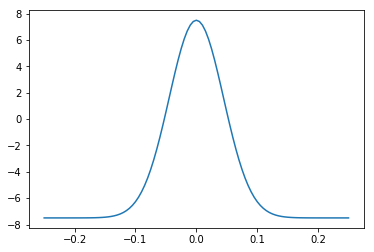

In [12]:
import matplotlib.pyplot as plt
from math import exp

x0 = -0.25
xT = 0.25
steps = 100
dx = (xT-x0)/steps
xs = [x0+i*dx for i in range(steps+1)]
ys = [15.*exp(-250.*(x**2))-7.5 for x in xs]

ax = plt.axes()
ax.plot(xs, ys)
plt.show()

Our bell curve in this case is sharply peaked in the area between 0.1 and 0, which means that the agent -- if it learns to select the next waypoint -- should learn to do so within this region. Our reward function for the termination policy is now minimizing the cross-entropy between the proposed distribution, and the policy distribution. This is straightforward to show, since:

\begin{equation}
H(p,q) = \mathbb{E}_{p}\left[-\log{q}\right]
\end{equation}

\begin{equation}
\nabla_{\theta}J(\theta) = \mathbb{E}_{\pi}\left[-\sum_{t=0}^{T-1}\log{\pi_{\theta}(a|s)}(Q^{\pi}(s,a)-V^{\pi}(s))\right]
\end{equation}

Since:

\begin{equation}
Q^{\pi}(s,a) = 
\end{equation}


Next, we'll try training the agent:

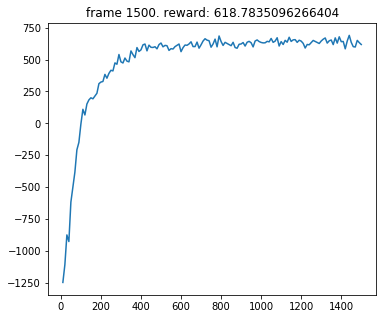

In [17]:
from types import MethodType

def term_reward(self, state):
    d1 = self.curr_dist
    term_rew = 15.*exp(-250.*(d1**2))-7.5
    return term_rew

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)
env_two.term_reward = MethodType(term_reward, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )

terminator = Terminator(state_dim, hidden_dim, 2)
term_agent = Agent(pi, beta, critic, terminator, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
term_opt = torch.optim.Adam(terminator.parameters())
term_ep, term_rew, term_agent = train_term(env_two, term_agent, crit_opt, term_opt, batch_size=2048, iterations=1500, log_interval=10, fname="gaussian")

##### 6.4.3.1 Visualization

In [9]:
env_one = gym.make("Trajectory-v0")

params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

fname = "gaussian_term.pth.tar"
pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )

terminator = Terminator(state_dim, hidden_dim, 2)
term_agent_check = Agent(pi, beta, critic, terminator, params["network_settings"])
term_agent_check.load_state_dict(torch.load("./"+fname))
print()
print("State dict loaded")
_ = rollout(env_one, term_agent_check, batch_size=2048, render=True)

[2019-07-18 14:31:18,769] Making new env: Trajectory-v0


Simulation parameters:
Aircraft mass:  0.6499999761581421
Gravity:  9.8100004196167
Torque coefficient:  7.500000265281415e-07
Thrust coefficient:  3.1299998227041215e-05
Maximum RPM:  3047.722428374999
Hover RPM:  2155.0651962782936
Hover Omega:  225.6778996211644
Action bandwidth:  334.22538049298026


Exception ignored in: <bound method Env.__del__ of <gym_aero.envs.trajectory_env.TrajectoryEnv object at 0x7feb8adf45c0>>
Traceback (most recent call last):
  File "/home/seanny/anaconda2/envs/python3.5/lib/python3.5/site-packages/gym/core.py", line 202, in __del__
    self.close()
  File "/home/seanny/anaconda2/envs/python3.5/lib/python3.5/site-packages/gym/core.py", line 167, in close
    self.render(close=True)
  File "/home/seanny/gym-aero/gym_aero/envs/trajectory_env.py", line 190, in render
    for g in [[0., 0., 0.]]+self.goal_list_xyz: 
AttributeError: 'TrajectoryEnv' object has no attribute 'goal_list_xyz'



State dict loaded


#### 6.4.4 Using Correlation

Finally, we'll try adding an additional term to the termination value function to incentivise better behaviour. We propose the function:

\begin{equation}
\mathcal{L} = -k_1 d_1^2 - k_2 d_1 d_2
\end{equation}

Some quick analysis of this function tells us that it will be maximized at the point $d_1 = 0$. Furthermore, the inclusion of the second term should help prevent the early switching problem that was noted earlier.

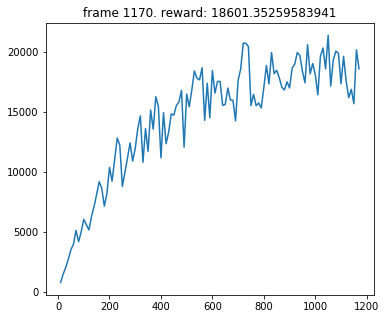

KeyboardInterrupt: 

In [6]:
from types import MethodType

def term_reward(self, state):
    xyz, _, _, _, _ = state
    d1 = self.curr_dist
    d2 = np.linalg.norm([x-g for x,g in zip(xyz, self.goal_xyz_next)])
    term_rew = -(15.*d1**2+d1*d2)
    return term_rew

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)
env_two.term_reward = MethodType(term_reward, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )

terminator = Terminator(state_dim, hidden_dim, 2)
term_agent = Agent(pi, beta, critic, terminator, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
term_opt = torch.optim.Adam(terminator.parameters())
term_ep, term_rew, term_agent = train_term(env_two, term_agent, crit_opt, term_opt, batch_size=1024, iterations=1500, log_interval=10, fname="modified_val")

#### 6.4.1 Visualization

In [8]:
from types import MethodType

fname = "modified_val_term.pth.tar"

def term_reward(self, state):
    xyz, _, _, _, _ = state
    d1 = self.curr_dist
    d2 = np.linalg.norm([x-g for x,g in zip(xyz, self.goal_xyz_next)])
    term_rew = -(15.*d1**2+d1*d2)
    return term_rew

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)
env_two.term_reward = MethodType(term_reward, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )

terminator = Terminator(state_dim, hidden_dim, 2)
term_agent_check = Agent(pi, beta, critic, terminator, params["network_settings"])
term_agent_check.load_state_dict(torch.load("./"+fname))
print()
print("State dict loaded")
_ = term_rollout(env_two, term_agent_check, batch_size=2048, render=True)

Simulation parameters:
Aircraft mass:  0.6499999761581421
Gravity:  9.8100004196167
Torque coefficient:  7.500000265281415e-07
Thrust coefficient:  3.1299998227041215e-05
Maximum RPM:  3047.722428374999
Hover RPM:  2155.0651962782936
Hover Omega:  225.6778996211644
Action bandwidth:  334.22538049298026

State dict loaded


This agent performs better than the ablative agents, but not as good as the one that was trained on the log-probability distance function.

### 6.5 Analysis -- Visualizing Trajectory Derivatives and the Closest Distance to the Current Waypoint
As discussed earlier, the reward is not necessarily the best measure of performance in our scenario, since we can arbitrarily tune the goal threshold to improve the return. We need to consider both failure modes for the agent relying on the discrete goal threshold -- creeping and jumping -- to determine the best measure of success. In the former case, the agent never gets past the current waypoint, so any agent that manages to do so is better by virtue of completing the trajectory. In the second case, the agent jumps through the waypoints, exhibiting high levels of acceleration, but manages to reach all waypoints (and achieves a high reward by virtue of this fact). We propose measuring the acceleration and switching distance from the goal to show that, in fact, our agent manages smoother flight through the trajectory.

Accordingly, we visualize both the trajectory derivatives -- to determine the smoothness of the path -- and the distance at which the termination policy switches to the next goal, below: 

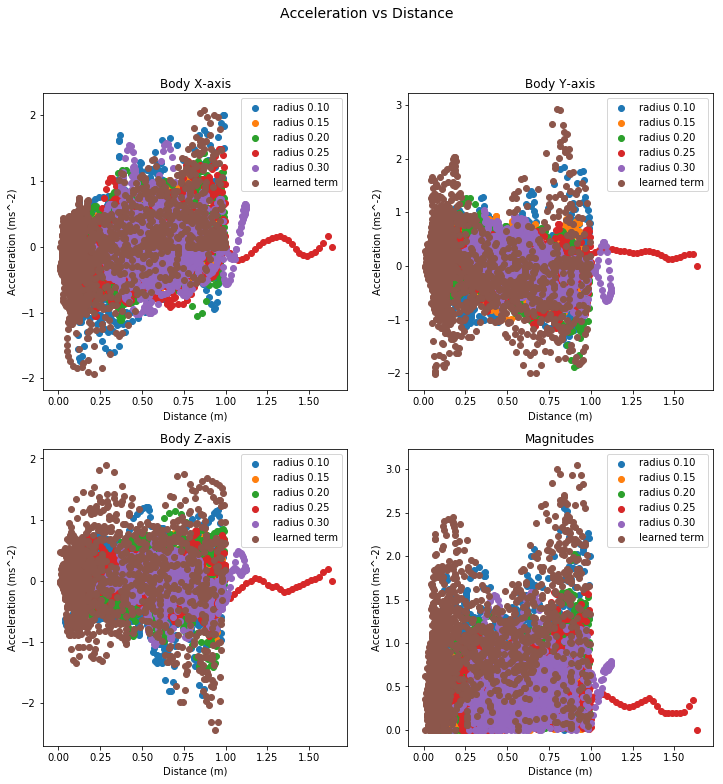

In [19]:
%matplotlib inline

env_one = gym.make("Trajectory-v0")
env_two = TrajectoryEnvTerm()

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = params["hidden_dim"]

names = ["main_0.1_rad_standard.pth.tar", 
         "0.15_rad_standard.pth.tar",
         "0.2_rad_standard.pth.tar",
         "0.25_rad_standard.pth.tar",
         "0.3_rad_standard.pth.tar",
         "log_gaussian_term.pth.tar"]

labels = ["radius 0.10",
          "radius 0.15",
          "radius 0.20",
          "radius 0.25",
          "radius 0.30",
          "learned term"]

trajectories = []
for n in names:
    if "term" in n:
        state_dim = env_two.observation_space.shape[0]
        action_dim = env_two.action_space.shape[0]
        hidden_dim = params["hidden_dim"]
        pi = Actor(state_dim, hidden_dim, action_dim)
        beta = Actor(state_dim, hidden_dim, action_dim)
        critic = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.Tanh(),
                        torch.nn.Linear(hidden_dim, hidden_dim),
                        torch.nn.Tanh(),
                        torch.nn.Linear(hidden_dim, 1)
                        )
        terminator = Terminator(state_dim, hidden_dim, 2)
        term_agent_check = Agent(pi, beta, critic, terminator, params["network_settings"])
        term_agent_check.load_state_dict(torch.load("./"+n))
        trajectory_term = term_rollout(env_two, term_agent, batch_size=2048)
        trajectories.append(trajectory_term)
    else:
        state_dim = env_one.observation_space.shape[0]
        action_dim = env_one.action_space.shape[0]
        hidden_dim = params["hidden_dim"]
        pi = Actor(state_dim, hidden_dim, action_dim)
        beta = Actor(state_dim, hidden_dim, action_dim)
        critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1))
        agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
        agent_check.load_state_dict(torch.load("./"+n))
        trajectory = rollout(env_one, agent_check, batch_size=2048)
        trajectories.append(trajectory)

clear_output(True)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle("Acceleration vs Distance", fontsize=14)
ax1.set_title("Body X-axis")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Acceleration (ms^-2)")
ax2.set_title("Body Y-axis")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Acceleration (ms^-2)")
ax3.set_title("Body Z-axis")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Acceleration (ms^-2)")
ax4.set_title("Magnitudes")
ax4.set_xlabel("Distance (m)")
ax4.set_ylabel("Acceleration (ms^-2)")

for trajectory in trajectories:
    states = torch.stack(trajectory["states"])
    masks = torch.stack(trajectory["masks"])
    derivatives = torch.stack([(states[i]-states[i-1])*(masks[i-1,0]/0.05) for i in range(1, states.size(0))])
    goal_dist = torch.sqrt(torch.sum(states[0:-1, 0:3]**2, dim=1)).unsqueeze(dim=1)
    ax1.scatter(goal_dist.cpu().numpy(), derivatives[:,9+0].cpu().numpy())
    ax2.scatter(goal_dist.cpu().numpy(), derivatives[:,9+1].cpu().numpy())
    ax3.scatter(goal_dist.cpu().numpy(), derivatives[:,9+2].cpu().numpy())
    normed = (derivatives[:,9+0].cpu().numpy()**2+derivatives[:,9+1].cpu().numpy()**2+derivatives[:,9+2].cpu().numpy()**2)**0.5
    ax4.scatter(goal_dist, normed)
    
ax1.legend(labels)
ax2.legend(labels)
ax3.legend(labels)
ax4.legend(labels)
plt.show()

As we can see from the above plots acceleration is broadly consistent, but the highest magnitudes are shown by the standard agent. Looking at a plot of the standard agent's behaviour, we can see that the highest magnitude accelerations typically occur immediately after triggering a shift to the next waypoint. That is, 

### 6.6 Analysis -- Learned Termination Distribution

We analyze the distance to the next waypoint below:

Simulation parameters:
Aircraft mass:  0.6499999761581421
Gravity:  9.8100004196167
Torque coefficient:  7.500000265281415e-07
Thrust coefficient:  3.1299998227041215e-05
Maximum RPM:  3047.722428374999
Hover RPM:  2155.0651962782936
Hover Omega:  225.6778996211644
Action bandwidth:  334.22538049298026


ValueError: need at least one array to concatenate

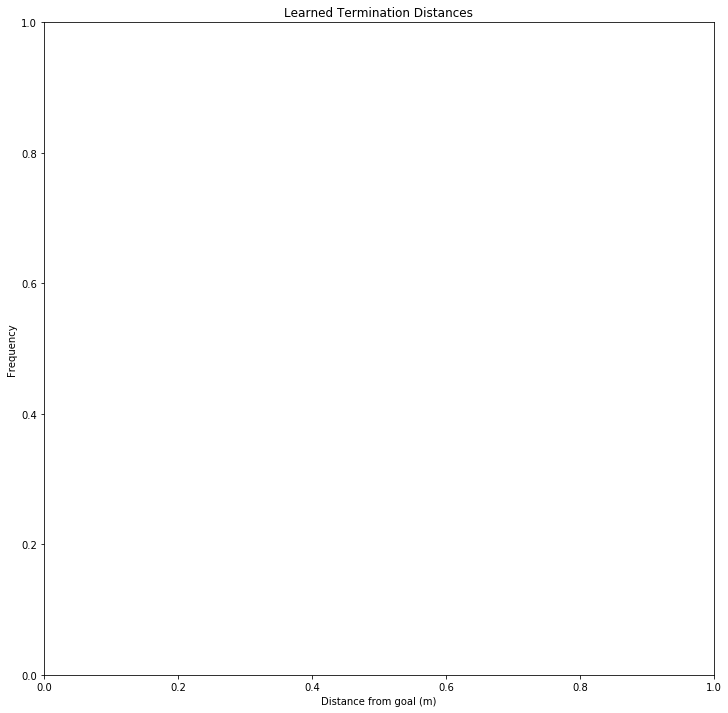

In [7]:
env_two = TrajectoryEnvTerm()

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

#names = ["log_gaussian_term.pth.tar",
#         "pi_val_term.pth.tar",
#         "gaussian_term.pth.tar",
#         "modified_val_term.pth.tar",
#         ]

#labels = ["log_gaussian",
#         "pi_val",
#         "gaussian",
#         "modified_val"
#         ]

names = ["gaussian_term.pth.tar"]
labels = ["gaussian"]

fig, ax_one = plt.subplots(1, 1, figsize=(12,12))
ax_one.set_title("Learned Termination Distances")
ax_one.set_xlabel("Distance from goal (m)")
ax_one.set_ylabel("Frequency")

for n in names:

    pi = Actor(state_dim, hidden_dim, action_dim)
    beta = Actor(state_dim, hidden_dim, action_dim)
    critic = torch.nn.Sequential(
                    torch.nn.Linear(state_dim, hidden_dim),
                    torch.nn.Tanh(),
                    torch.nn.Linear(hidden_dim, hidden_dim),
                    torch.nn.Tanh(),
                    torch.nn.Linear(hidden_dim, 1)
                    )
    terminator = Terminator(state_dim, hidden_dim, 2)
    term_agent_check = Agent(pi, beta, critic, terminator, params["network_settings"])
    term_agent_check.load_state_dict(torch.load("./"+n))
    trajectory_term = term_rollout(env_two, term_agent_check, batch_size=8192)

    terminations = trajectory_term["terminations"]
    states_term = trajectory_term["states"]
    distances_term = [np.linalg.norm(s[19:22].cpu().numpy()) for s in states_term]
    distances_terminated = [np.linalg.norm(s[19:22].cpu().numpy())*(t.cpu().numpy()) for s, t in zip(states_term, terminations)]
    distances_terminated = np.trim_zeros(distances_terminated)
    d = np.hstack(distances_terminated)

    ax_one.hist(d[d != 0], bins=50, alpha = 0.85)
ax_one.legend(labels)
plt.show()

As we can see from the histogram plots, the agent that learns its own termination conditions has a much larger variance in terms of distance from the goal. We also visualize the distances at which the agent terminated the current waypoint, and see that for obtuse angles, the terminations are nicely clustered around the goal. However, for acute angles, this is not the case, leading to a second population further from the goal. This highlights one of the current limitations of our technique, which is the tendency of the aircraft to prematurely skip through acute angles.

### 6.7 Analysis -- Generalization to Trajectories of arbitrary length
In the below code, we generate trajectories of random length, and test the ability of our agent to successfully navigate them.

In [ ]:
import gym
import gym_aero
import gym_aero.envs.trajectory_env as trajectory_env
import random
from math import exp

class TrajectoryEnvArbitraryLen(trajectory_env.TrajectoryEnv):
    def __init__(self):
        super(TrajectoryEnvArbitraryLen, self).__init__()
    
    def step(self, action):
        commanded_rpm = self.translate_action(action)
        xyz, zeta, uvw, pqr = super(trajectory_env.TrajectoryEnv, self).step(commanded_rpm)
        sin_zeta = [sin(z) for z in zeta]
        cos_zeta = [cos(z) for z in zeta]
        current_rpm = self.get_rpm()
        normalized_rpm = [rpm/self.max_rpm for rpm in current_rpm]
        self.set_current_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        reward, info = self.reward((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        if self.curr_dist <= self.goal_thresh: self.next_goal()
        done = self.terminal()
        switched = True if self.curr_dist <= self.goal_thresh and self.goal_xyz != self.prev_goal_xyz else False
        p = 0 if switched is False else 1
        obs = self.get_state_obs((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        self.set_prev_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        self.t += 1
        return obs, reward, done, info, switched, p
    
    def reset(self):
        self.traj_len = random.randint(2,10)
        
        # terminate previous sim, initialize new one
        state = super(trajectory_env.TrajectoryEnv, self).reset()
        xyz, sin_zeta, cos_zeta, uvw, pqr, normalized_rpm = state
        
        # generate waypoint positions
        self.goal_list_xyz = []
        xyz_temp = [0., 0., 0.]
        for _ in range(self.traj_len):
            goal = self.generate_waypoint()
            temp = [x + g for x,g in zip(xyz_temp, goal)]
            self.goal_list_xyz.append(temp)
            xyz_temp = temp
        
        # generate goal angles
        self.goal_list_zeta = []
        i = self.traj_len-2
        while True:
            temp = self.goal_list_xyz[i+1]
            xyz = [0., 0., 0.] if i < 0 else self.goal_list_xyz[i]
            yaw = self.generate_yaw(temp, xyz)
            self.goal_list_zeta.append(yaw)
            if i < 0: break
            i -= 1
        
        # set current goal, next goal
        self.goal = 0
        self.goal_next = self.goal+1
        self.goal_xyz = self.goal_list_xyz[self.goal]
        self.goal_xyz_next = self.goal_list_xyz[self.goal_next]
        self.goal_zeta = self.goal_list_zeta[self.goal]
        self.goal_zeta_next = self.goal_list_zeta[self.goal_next]
        self.prev_goal_xyz = self.goal_xyz
        
        # calculate current distance to goals
        self.set_current_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), self.hov_rpm_, normalized_rpm)
        
        # get state observation
        obs = self.get_state_obs((xyz, sin_zeta, cos_zeta, uvw, pqr), self.hov_rpm_, normalized_rpm)
        
        # set previous distances
        self.set_prev_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), self.hov_rpm_, normalized_rpm)
        return obs
    
    def next_goal(self):
        if not self.goal >= len(self.goal_list_xyz)-1:
            self.time_state = float(self.T)
            self.t = 0
            self.prev_goal_xyz = self.goal_list_xyz[self.goal]
            self.goal += 1
            self.goal_xyz = self.goal_list_xyz[self.goal]
            self.goal_zeta = self.goal_list_zeta[self.goal]
        if self.goal_next >= len(self.goal_list_xyz)-1:
            self.goal_xyz_next = [0., 0., 0.]
            self.goal_zeta_next = [0., 0., 0.]
        else:
            self.goal_next += 1
            self.goal_xyz_next = self.goal_list_xyz[self.goal_next]
            self.goal_zeta_next = self.goal_list_zeta[self.goal_next]
    
    
class TrajectoryEnvTermArbitraryLen(TrajectoryEnvTerm):
    def __init__(self):
        super(TrajectoryEnvTermArbitraryLen, self).__init__()
        
    def step(self, action, term):
        commanded_rpm = self.translate_action(action)
        xyz, zeta, uvw, pqr = super(trajectory_env.TrajectoryEnv, self).step(commanded_rpm)
        sin_zeta = [sin(z) for z in zeta]
        cos_zeta = [cos(z) for z in zeta]
        current_rpm = self.get_rpm()
        normalized_rpm = [rpm/self.max_rpm for rpm in current_rpm]
        self.set_current_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        reward, info = self.reward((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        term_rew = self.term_reward((xyz, sin_zeta, cos_zeta, uvw, pqr)) if term == 1 else 0.
        if term == 1: self.next_goal()
        done = self.terminal()
        switched = True if term and self.goal_xyz != self.prev_goal_xyz else False
        p = 0 if switched is False else exp(-self.prev_dist**2)
        obs = self.get_state_obs((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        self.set_prev_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), commanded_rpm, normalized_rpm)
        info.update({"term_rew" : term_rew})
        self.t += 1
        return obs, reward, done, info, switched, p

    def reset(self):
        self.traj_len = random.randint(2,10)
        
        state = super(trajectory_env.TrajectoryEnv, self).reset()
        xyz, sin_zeta, cos_zeta, uvw, pqr, normalized_rpm = state
        
        self.goal_list_xyz = []
        xyz_temp = [0., 0., 0.]
        for _ in range(self.traj_len):
            goal = self.generate_waypoint()
            temp = [x + g for x,g in zip(xyz_temp, goal)]
            self.goal_list_xyz.append(temp)
            xyz_temp = temp
        
        self.goal_list_zeta = []
        i = self.traj_len-2
        while True:
            temp = self.goal_list_xyz[i+1]
            xyz = [0., 0., 0.] if i < 0 else self.goal_list_xyz[i]
            yaw = self.generate_yaw(temp, xyz)
            self.goal_list_zeta.append(yaw)
            if i < 0: break
            i -= 1
        
        self.goal = 0
        self.goal_next = self.goal+1
        self.goal_xyz = self.goal_list_xyz[self.goal]
        self.goal_xyz_next = self.goal_list_xyz[self.goal_next]
        self.goal_zeta = self.goal_list_zeta[self.goal]
        self.goal_zeta_next = self.goal_list_zeta[self.goal_next]
        self.prev_goal_xyz = self.goal_xyz
        self.set_current_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), self.hov_rpm_, normalized_rpm)
        obs = self.get_state_obs((xyz, sin_zeta, cos_zeta, uvw, pqr), self.hov_rpm_, normalized_rpm)
        self.set_prev_dists((xyz, sin_zeta, cos_zeta, uvw, pqr), self.hov_rpm_, normalized_rpm)
        return obs
    
    def next_goal(self):
        if not self.goal >= len(self.goal_list_xyz)-1:
            self.time_state = float(self.T)
            self.t = 0
            self.prev_goal_xyz = self.goal_list_xyz[self.goal]
            self.goal += 1
            self.goal_xyz = self.goal_list_xyz[self.goal]
            self.goal_zeta = self.goal_list_zeta[self.goal]
        if self.goal_next >= len(self.goal_list_xyz)-1:
            self.goal_xyz_next = [0., 0., 0.]
            self.goal_zeta_next = [0., 0., 0.]
        else:
            self.goal_next += 1
            self.goal_xyz_next = self.goal_list_xyz[self.goal_next]
            self.goal_zeta_next = self.goal_list_zeta[self.goal_next]

Next we'll modify our rollout function to get the information needed:

In [ ]:
def arb_rollout(env, agent, batch_size=2048, render=False):
    num_steps = 0
    print()
    while num_steps < batch_size:
        state = torch.Tensor(env.reset()).to(device)
        num_goals = env.traj_len
        print("number of goals: ", num_goals)
        t = 0
        j = 1
        percentage = 0
        sw, pr = [], []
        done = False
        while not done:
            if render: env.render()
            action, value, log_prob = agent.select_action(state)
            next_state, reward, done, info, switched, p = env.step(action.cpu().data.numpy())
            sw.append(switched)
            pr.append(p)
            next_state = torch.Tensor(next_state).to(device)   
            state = next_state
            t += 1
        percentage = (percentage*(j-1)+(sum(pr)/num_goals))/j
        print("goals reached: ", sum(pr))
        print("percentage: ", sum(pr)/num_goals)
        print("average: ", percentage)
        j += 1
        num_steps += t
    if render: env.render(close=True)
    return percentage

def arb_term_rollout(env, agent, batch_size=2048, render=False):
    num_steps = 0
    print()
    while num_steps < batch_size:
        state = torch.Tensor(env.reset()).to(device)
        num_goals = env.traj_len
        print("number of goals: ", num_goals)
        t = 0
        j = 1
        percentage = 0
        hidden = None
        sw, pr = [], []
        done = False
        while not done:
            if render: env.render()
            action, value, log_prob = agent.select_action(state)
            term, term_val, hidden, term_log_prob = agent.terminate(state, hidden)
            next_state, reward, done, info, switched, p = env.step(action.cpu().data.numpy(), term.cpu().item())
            sw.append(switched)
            pr.append(p)
            term_rew = info["term_rew"]
            next_state = torch.Tensor(next_state).to(device)    
            state = next_state
            t += 1
        percentage = (percentage*(j-1)+(sum(pr)/num_goals))/j
        print("goals reached: ", sum(pr))
        print("percentage: ", sum(pr)/num_goals)
        print("average: ", percentage)
        j += 1
        num_steps += t
    if render: env.render(close=True)
    return percentage

Next, we'll run the code:

In [ ]:
%matplotlib inline

env_one = TrajectoryEnvArbitraryLen()
env_two = TrajectoryEnvTermArbitraryLen()

params = cfg.trpo

names = ["main_0.1_rad_standard.pth.tar",
         "0.15_rad_standard.pth.tar",
         "0.2_rad_standard.pth.tar",
         "0.25_rad_standard.pth.tar",
         "0.3_rad_standard.pth.tar",
         "log_gaussian_term.pth.tar",
         "mu_val_term.pth.tar",
         "pi_val_term.pth.tar",
         "gaussian_term.pth.tar",
         "modified_val_term.pth.tar"]

labels = ["radius 0.10",
          "radius 0.15",
          "radius 0.20",
          "radius 0.25",
          "radius 0.30",
          "log_gaussian",
          "mu_val",
          "pi_val",
          "gaussian",
          "modified_val"]

print()
for i, n in enumerate(names):
    if "term" in n:
        state_dim = env_two.observation_space.shape[0]
        action_dim = env_two.action_space.shape[0]
        hidden_dim = params["hidden_dim"]
        pi = Actor(state_dim, hidden_dim, action_dim)
        beta = Actor(state_dim, hidden_dim, action_dim)
        critic = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.Tanh(),
                        torch.nn.Linear(hidden_dim, hidden_dim),
                        torch.nn.Tanh(),
                        torch.nn.Linear(hidden_dim, 1)
                        )
        terminator = Terminator(state_dim, hidden_dim, 2)
        term_agent_check = Agent(pi, beta, critic, terminator, params["network_settings"])
        term_agent_check.load_state_dict(torch.load("./"+n))
        completion_score = arb_term_rollout(env_two, term_agent_check, batch_size=2048)
        print(labels[i]+" completion score: ", completion_score)
    else:
        state_dim = env_one.observation_space.shape[0]
        action_dim = env_one.action_space.shape[0]
        hidden_dim = params["hidden_dim"]
        pi = Actor(state_dim, hidden_dim, action_dim)
        beta = Actor(state_dim, hidden_dim, action_dim)
        critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1))
        agent_check = trpo_peb.TRPO(pi, beta, critic, params["network_settings"])
        agent_check.load_state_dict(torch.load("./"+n))
        completion_score = arb_rollout(env_one, agent_check, batch_size=2048)
        print(labels[i]+" completion score: ", completion_score)

### 6.8 Analysis -- Comparison on a standard task
The goal of this analysis is to show that our proposed method is not actively detrimental compared to a standard policy search. This is reasonably self-evident as -- in the standard case -- the agent will quickly learn that attempting to switch to a new goal induces a penalty, and has no effect on the return of the control policy.

## 7. Discussion

### 7.1 Limitations
Presently, the agent is effective in learning smooth flight through sequences of obtuse angles, but switches prematurely when faced with acute angles. We believe this is a problem of the agent getting stuck in local minima, and that solving this problem will also help with utilizing future waypoints more effectively.

## 8. Related Work

We present related work in two separate fields: quadrotor flight control, and existing applications of reinforcement learning; and reinforcement learning as it has been applied to games. 

### 8.1 Reinforcement Learning in Quadrotor Control
RL applications to quadrotors are ubiquitous,

### 8.2 Reinforcement Learning in Games

(sunehag, 2017) introduced value-decomposition networks to train multi-agent policies for cooperative games; we arrived at a similar application from the perspective of a single hierarchical agent, which suggests that some hierarchical agents can be re-framed as a cooperative multi-agent problem. Aside from this, our work is separated by fundamental algorithmic differences. Furthermore, our agent is designed to operate as part of a more traditional hierarchical framework rather than in a cooperate multi-agent setting.

(haarnoja, 2018) used value function composition to train robotic arms for new tasks by combining the value functions of previously trained policies. Our work is distinct in both its direction and training method; whereas (haarnoja, 2018) uses the online Soft Q-Learning algorithm, we use Monte Carlo policy gradients. Furthermore, we don't train separate value functions before combining them; rather, all components of our agent are trained end-to-end simultaneously.

(bacon, 2017) used the termination gradient theorem to learn when to terminate a call-and-return options framework with tabular intra-options. Our work is distinct in several key ways: firstly, our environment consists of continuous states and actions, and so we use neural network function approximators to parameterize our policies and critics. Secondly, we use the parameterized skills framework, rather than the call-and-return architecture. Accordingly, we don't use the termination gradient theorem, and instead used value function composition to learn a termination policy. We provide a comparison with the termination gradient theorem in Appendix A, and show that it offers no improvement over a standard baseline in our case.

(vezhnevets, 2017) proposed Fuedal networks, in which a manager selects sub-goals, and a worker achieves those sub-goals based on an intrinsic reward signal. This is conceptually similar to the parameterized skills framework we use, based on (dann, 2018; dann, 2018a). Our work is distinct in that we assume a set of goals is given \textit{a priori}, and we are instead learning when we have actually reached a goal. Our termination policy $\beta$ is distinct from the manager policy in (vezhnevets, 2017), in that it executes a different task, and acts on the same frequency as the control network. 

Finally, UVFAs are an important component of our architecture, and many hierarchical architectures in general (see \cite{dann2018exploration,dann2018integrating,andrychowicz2017hindsight} for notable examples). Though we use UVFAs, we extend the concept to a more general one of context, where context can include not only sub-goals, but other factors of interest.

## 9. Conclusions

## 10. References

## 11. Appendix A

### 11.1 Termination Gradient Theorem

In the following block of code, we implement the termination gradient theorem [], to show that it a) does not specifically apply to our case, and that b) it performs worse than our proposed methodology.

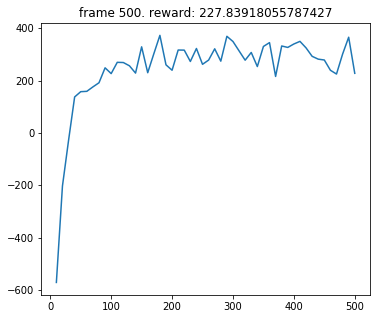

In [8]:
from types import MethodType

class AgentIV(Agent):
    def __init__(self, pi, beta, critic, terminator, params):
        super(AgentIV, self).__init__(pi, beta, critic, terminator, params)
        
    def update(self, crit_opt, term_opt, trajectory):
        rewards = torch.stack(trajectory["rewards"])
        masks = torch.stack(trajectory["masks"])
        states = torch.stack(trajectory["states"])
        next_states = torch.stack(trajectory["next_states"])
        term_log_probs = torch.stack(trajectory["term_log_probs"])
        term_rews = torch.stack(trajectory["term_rew"])
        term_vals = torch.stack(trajectory["term_val"]).squeeze(1)
        term_hiddens = trajectory["hiddens"]
        hxs = torch.stack([x[0] for x in term_hiddens])
        cxs = torch.stack([x[1] for x in term_hiddens])
        
        term_returns = torch.Tensor(rewards.size(0),1).to(self.device)
        term_deltas = torch.Tensor(rewards.size(0),1).to(self.device)
        term_advantages = torch.Tensor(rewards.size(0),1).to(self.device)
        
        term_prev_return = 0
        term_prev_value = 0
        term_prev_advantage = 0
        
        for i in reversed(range(rewards.size(0))):
            if masks[i] == 0:
                _, term_next_val, _, _ = self.terminate(next_states[i].unsqueeze(0), (hxs[i], cxs[i]))
                term_prev_return = term_next_val.item()
                term_prev_value = term_next_val.item()
            
            term_returns[i] = rewards[i]+self.gamma*term_prev_return*masks[i]
            term_deltas[i] = rewards[i]+self.gamma*term_prev_value*masks[i]-term_vals.data[i]
            
            term_prev_return = term_returns[i, 0]
            term_prev_value = term_vals.data[i, 0]
            
        term_returns = (term_returns-term_returns.mean())/(term_returns.std())
        term_deltas = (term_deltas-term_deltas.mean())/(term_deltas.std())
        
        # update terminator
        term_opt.zero_grad()
        term_crit_loss = F.smooth_l1_loss(term_vals, term_returns)
        term_pol_loss = term_log_probs[0:-1]*term_deltas[1:] 
        term_loss = term_pol_loss+term_crit_loss
        term_loss = term_loss.mean()
        term_loss.backward()
        term_opt.step()
        
        # call the base update function
        super(Agent, self).update(crit_opt, trajectory)

env_two = TrajectoryEnvTerm()
env_two.reward = MethodType(reward_func, env_two)

params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = params["hidden_dim"]

pi = Actor(state_dim, hidden_dim, action_dim)
beta = Actor(state_dim, hidden_dim, action_dim)
critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_dim, 1)
                )
terminator = Terminator(state_dim, hidden_dim, 2)
term_agent = AgentIV(pi, beta, critic, terminator, params["network_settings"])
crit_opt = torch.optim.Adam(critic.parameters())
term_opt = torch.optim.Adam(terminator.parameters())
term_ep, term_rew, term_agent = train_term(env_two, term_agent, crit_opt, term_opt, batch_size=4096, iterations=500, log_interval=10, fname="term_grad")

### 11.2 Comparison With Motion-Planning-Based Policies

In the following block of code, we construct a motion-planning-based environment, and train a policy on it.

This agent learns smooth navigation between the waypoints by embedding the path-planner into the policy. However, it suffers from a few key limitations:

1. It doesn't generalize to an arbitrary number of waypoints without significant modification;
2. If incorporating these modifications (such as datum shifting), the agent can still show signs of instability (e.g. violent oscillations when the datum is shifted); and,
3. It is more difficult to train than our representation, and achieves fewer goals.